In [116]:
# For compareson, I also test the same task using a optimize version of BERT RoBERTa
# This was not applied on the product due to size limitation
# Loading required dependencies
import pandas as pd
from transformers import get_scheduler
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,confusion_matrix
import optuna
import os
from nltk.stem import PorterStemmer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from lion_pytorch import Lion # Lion Optimizer


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu' )
data_path = 'full_Data.csv'
#device = torch.device("mps" if torch.backends.mps.is_available() and device != 'cuda' else 'cpu' )
df = pd.read_csv(data_path,index_col= [0])

In [3]:
#Remove na and duplicate
df.drop_duplicates(inplace=True)
df.dropna(inplace = True)

Average number of words in an SMS: 1259.6406191879596


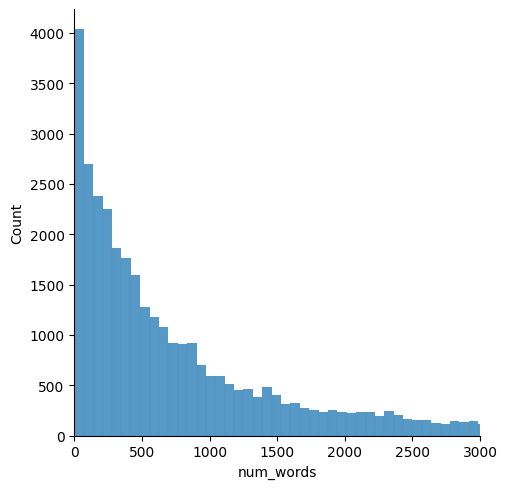

In [4]:
df['num_words'] = df.Text.apply(len)
sns.displot(df.num_words)
plt.xlim(0, 3000)
print("Average number of words in an SMS:",df.num_words.mean())

In [5]:
#Model selection
#Bert would have be a good choice however it only take up to 512 token(words)
#Whishing tring Bert,I also want to test out model accept long tokens 

In [6]:
df.drop(df[df['num_words'] < 8].index,inplace = True)

In [7]:
df = df.reset_index(drop = True)

In [8]:
df.sort_values(by ='num_words',ascending = False)
df.loc[18703].Text # The longest text seems to be some sort of news copy, and don't have any partical meaning for our task

'enron : a wake - up call\nthe wall street journal , 12 / 04 / 01\nfall of a power giant : dynegy hits back at enron with lawsuit - - - claim is that failed merger entitles concern to get northern natural gas\nthe wall street journal , 12 / 04 / 01\nenron secures $ 1 . 5 billion in new financing - - - j . p . morgan , citigroup pact is first step ; now , lifeline is sought for trading unit\nthe wall street journal , 12 / 04 / 01\nfall of a power giant : burst of chapter 11 filings marks big year for the bankruptcy bar\nthe wall street journal , 12 / 04 / 01\nfall of a power giant : now is the time for creditors to vie against each other\nthe wall street journal , 12 / 04 / 01\nauditor andersen is added to enron 401 ( k ) lawsuit\nthe wall street journal , 12 / 04 / 01\nstadium jinx : what to call enron field ? ` enron folds , \' maybe - - - firms that put their names on arenas hit hard times ; former trans world dome\nthe wall street journal , 12 / 04 / 01\nas kpn prepares to sell new 

## Model set up and training
### Simlair to the BERT version, I am training the classifier only to save computation power

In [120]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 768
BATCH_SIZE = 64
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained('roberta-base',do_lower_case = True,truncation = True)
lemma = WordNetLemmatizer()

In [14]:
def text_cleaning(text):
    text = re.sub(r'[^a-zA-Z0-9\s]',' ',text)
    text = re.sub(r'\n','',text )
    text = re.sub(r'\t','',text )
    re.sub(r'\s{2,}', ' ', text)
    stop_words = set(stopwords.words('english'))
    tokens = tokneizer.tokenize(text)
    tokens = [lemma.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens


In [110]:
class spamdata(Dataset):
    def __init__(self,df,tokenizer,max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text = self.df.Text
        self.label = self.df.Label

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        text = str(self.text[idx])
        text = re.sub(r'[^a-zA-Z0-9\s]',' ',text)
        text = re.sub(r'\n','',text )
        text = re.sub(r'\t','',text )
        re.sub(r'\s{2,}', ' ', text)
        stop_words = set(stopwords.words('english'))
        tokens = tokenizer.tokenize(text)
        tokens = [lemma.lemmatize(token) for token in tokens if token not in stop_words]

        inputs = self.tokenizer.encode_plus(
            text = text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask =True,
            turncation = True
        )
        ids = torch.tensor(inputs['input_ids'])
        mask = torch.tensor(inputs['attention_mask'])
        label = torch.tensor(self.label.iloc[idx])
        return ids,mask,label

In [111]:
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
#Train val test split 80/10/10
train_input,_ = train_test_split(df,test_size=.2,random_state= 23)
val_input,test_input = train_test_split(_,test_size=.5,random_state= 23)

In [109]:
train_input.reset_index(drop  = True,inplace = True)
val_input.reset_index(drop  = True,inplace = True)
test_input.reset_index(drop  = True,inplace = True)

In [121]:
train_dataset = spamdata(df = train_input,tokenizer = tokenizer,max_len=MAX_LEN)
valid_dataset = spamdata(df = val_input,tokenizer = tokenizer,max_len=MAX_LEN)
test_dataset = spamdata(df = test_input,tokenizer = tokenizer,max_len=MAX_LEN)

In [122]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [145]:
class robertamodel(nn.Module):
    def __init__(self,freeze_percentage = 0.8):
        super().__init__()
        self.layer1 = AutoModelForSequenceClassification.from_pretrained('roberta-base')
        self.pre_classifer = torch.nn.Linear(768,768)
        self.dropout = nn.Dropout(p = .3)
        self.classifier = nn.Linear(768,2,bias = True)

        # Freeze a percentage of the layers
        num_total_layers = len(self.layer1.roberta.encoder.layer)
        num_layers_to_freeze = int(num_total_layers * freeze_percentage)
        for layer in self.layer1.roberta.encoder.layer[:num_layers_to_freeze]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self,inputs, attention_mask):
        output_1 = self.l1(input,attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:,0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

    

In [154]:
#Define optimizer and loss function
model = robertamodel(freeze_percentage=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = Lion(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

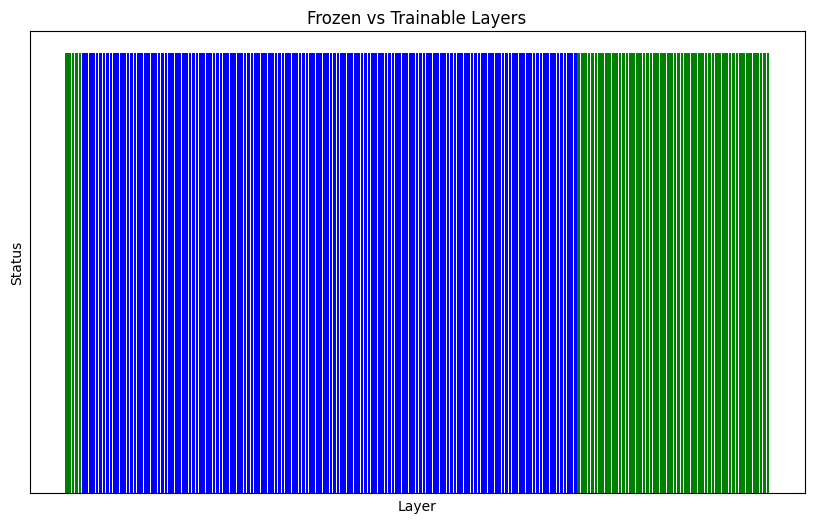

In [155]:
layer_names = []
layer_status = []

# Check if layers are frozen
for name, param in model.named_parameters():
    layer_names.append(name)
    if not param.requires_grad:
        layer_status.append("Frozen")
    else:
        layer_status.append("Trainable")

# Plotting the layer status
plt.figure(figsize=(10, 6))
plt.bar(layer_names, [1] * len(layer_names), color=["blue" if status == "Frozen" else "green" for status in layer_status])
plt.xlabel("Layer")
plt.ylabel("Status")
plt.title("Frozen vs Trainable Layers")
# Hide x-axis and y-axis ticks
plt.xticks([])
plt.yticks([])
plt.show()

In [153]:
train_loss = 0
train_losses = 0
valid_losses = 0

